### Sequence scoring, humanness and identification of problematic residues or regions
In this notebook, we illustrate how to use the SequenceScoringTool to score sequences for
humanness, assign them to clusters in the humanness model, find potentially problematic
residues and motifs, and retrieve the corresponding cluster for a sequence.

In [13]:
from antpack import SequenceScoringTool, SingleChainAnnotator
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

score_tool = SequenceScoringTool(normalization="none")
annotator = SingleChainAnnotator()

my_sequence = "DIELTQSPASLSASVGETVTITCQASENIYSYLAWHQQKQGKSPQLLVYNAKTLAGGVSSRFSGSGSGTHFSLKIKSLQPEDFGIYYCQHHYGILPTFGGGTKLEIK"

Note that we don't have to tell score_tool whether the sequence is heavy or light -- it will figure that
out using SingleChainAnnotator.

There are various flags we can set to exclude gaps, terminal
deletions, or a user-defined list of positions. Excluding other regions
can be useful if 1) the sequence has large deletions we'd like to ignore or 2) we just want to score
one specific region, e.g. a framework region. We can get a mask that excludes all except a specific
region by calling ```get_standard_mask```, e.g. ```score_tool.get_standard_mask(chain_type="H", region="fmwk1", cdr_labeling_scheme="kabat")```
will get a mask that excludes all regions of the sequence except Kabat-defined framework 1 (using IMGT numbering). This can then
be passed to score_seqs.

In [3]:
scores = score_tool.score_seqs([my_sequence], mask_terminal_dels = False, mask_gaps = False,
                             mode="score", custom_light_mask = None,
                              custom_heavy_mask = None)
print(scores)

[-144.48811766]


The sequence scoring tool can be set to normalize scores, but this is mostly useful if combining scores across different chains or scoring specific regions. Here we are using an unnormalized score. Refer to the "Humanness evaluation" section of the docs (see main page) and you'll notice that -144 is low. This sequence is not very human. That makes sense because this
is the light chain of Abagovamab, a mouse antibody. Next, we'll find the closest cluster to the sequence in the light chain model
(since this is a light chain) and see what this can tell us about what regions of the sequence are less human.

In [4]:
best_cluster_idx, chain_name = score_tool.get_closest_clusters(my_sequence, nclusters = 1)

It looks like the closest cluster to this sequence is cluster 343.

In [5]:
print(best_cluster_idx)

[343]


Let's pull cluster 343.

In [6]:
cluster_probs, cluster_weight, aa_list = score_tool.retrieve_cluster(343, chain_type = chain_name)

Each cluster in the mixture model is itself a probability distribution of length 141 for light
chains and length 173 for heavy (the length of the IMGT numbered input sequence, after incorporating
positions for insertions that are common in the training set even if not present in this particular
sequence). 

In [7]:
cluster_probs.shape

(1, 141, 21)

If we visualize this particular cluster, it looks like this. Note again
that it's a distribution and we could in principle sample from it
to generate more sequences.

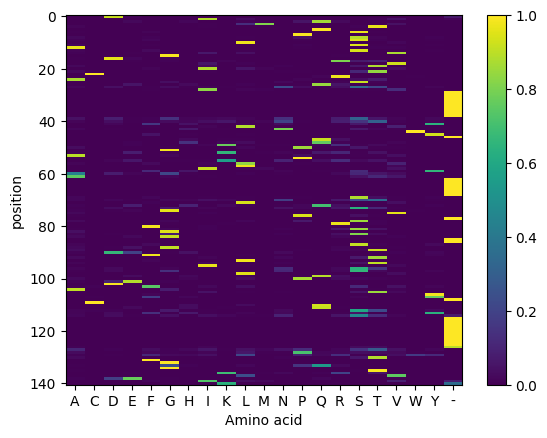

In [8]:

plt.imshow(cluster_probs[0,:,:], aspect="auto", interpolation="none")
plt.ylabel("position")
plt.xlabel("Amino acid")
plt.xticks(np.arange(21), aa_list)
plt.colorbar()

We want to see the log-probability of each amino acid in the input sequence given this cluster,
ignoring the IMGT positions that are common in some training sequences but are not filled here. In older AntPack versions this was possible but a little cumbersome. Starting in AntPack v0.4 it's fairly straightforward:

In [10]:
chain_type, relevant_probs, most_likely_aas = score_tool.calc_per_aa_probs(seq=my_sequence, cluster_id=343)

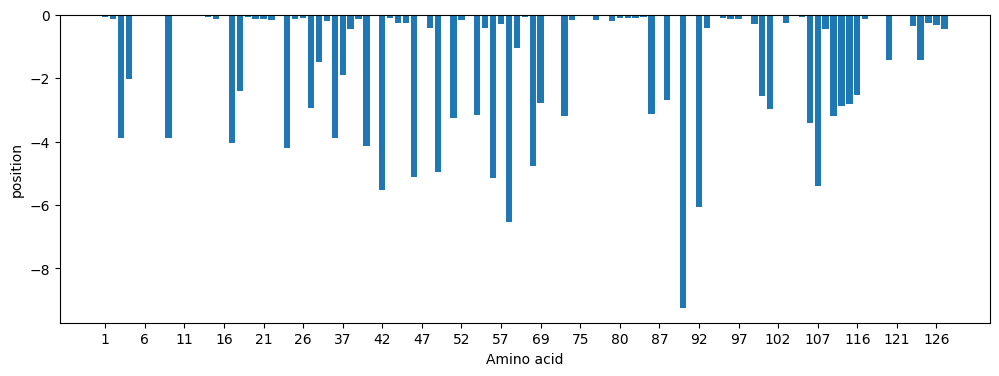

In [17]:
f, ax = plt.subplots(1, figsize=(12,4))

plt.bar(np.arange(relevant_probs.shape[0]), relevant_probs)
plt.ylabel("position")
plt.xlabel("Amino acid")

# Let's add the IMGT numbering to the x-axis. Just to make this
# easier to look at we'll only use every one in five tokens.
nmbr, _, _, _ = annotator.analyze_seq(my_sequence)
_=plt.xticks(np.arange(relevant_probs.shape[0])[::5], nmbr[::5])

Notice that this is the LOG probability, so lower is worse. There are a lot of amino acids in this sequence
with low probability even using the closest cluster -- that's because this is a mouse antibody so it needs
to be humanized. The worst one is at IMGT 90:

In [22]:
worst_position = np.argmin(relevant_probs)
print(my_sequence[worst_position])
print(nmbr[worst_position])

K
90


The most unfavorable position in the sequence is 73 (numbering from zero) in the original sequence,
which corresponds to IMGT 90. Here the sequence has K, while T is much more common in humans both in general
and in this cluster. One way to humanize this sequence would
be to make it more like cluster 343, i.e. to change some of the amino acids in the sequence to an amino acid
that's more likely at that position given cluster 343. We could use any other cluster in the light mixture
model, of course, and it's often a good idea to look at what some other clusters close to this sequence look
like as well. We can call ```get_closest_clusters``` to get e.g. the 2 or 3 clusters closest to this sequence.

Alternatively, we can use the built-in humanization tool, which uses a very generic procedure that we will
illustrate here.

Of these two approaches, we recommend the more tedious DIY extract close clusters and figure out which residues
you'd like to change approach. Humanization involves some important tradeoffs, and it's a good idea to think
about these carefully. Still, we'll illustrate the build-in generic approach here just for fun.

In [18]:
# Any value <= 1 for s_thresh will yield a straight CDR graft. That will improve humanness as much as
# possible, but will change large regions of the sequence.
score1, mutations1, sequence1 = score_tool.suggest_humanizing_mutations(my_sequence, s_thresh = 1)

score2, mutations2, sequence2 = score_tool.suggest_humanizing_mutations(my_sequence, s_thresh = 1.1)
score3, mutations3, sequence3 = score_tool.suggest_humanizing_mutations(my_sequence, s_thresh = 1.25)

In [19]:
print(f"Straight graft: {len(mutations1)} changes to original sequence, score {score1}")
print(f"1.10 threshold: {len(mutations2)} changes to original sequence, score {score2}")
print(f"1.25 threshold: {len(mutations3)} changes to original sequence, score {score3}")

Straight graft: 19 changes to original sequence, score -77.4538374417135
1.10 threshold: 15 changes to original sequence, score -83.44778045374068
1.25 threshold: 10 changes to original sequence, score -96.68713332179915


Any of these options yields a large improvement in the humanness score for this chain, but with different
numbers of mutations to the input.